## Кредитный Скоринг

#### Описание задачи
Дана выборка заявок на кредитный продукт. Про заявителей известны различные данные на момент заполнения анкеты. По части выборки (train, validate) известны результаты пользования кредитом (случился дефолт или нет), а по другой части(test) результаты известны только организаторам. Необходимо извлечь зависимость из имеющихся данных о заявителях и фактом наличия дефолта, и предсказать результат на тестовых данных.
В качестве метрики используется [AUC](https://www.kaggle.com/wiki/AreaUnderCurve).
#### Описание выборки  

##### APPLICATION_INFO.csv  
 - **id** - идентификатор счета
 - **application_dt** -  Дата подачи заявки
 - **sample_cd** -  Категория выборки
 - **education_cd** -  Образование
 - **gender_cd** -  Пол
 - **age** -  Возраст
 - **car_own_flg** -  Флаг наличия автомобиля
 - **car_type_flg** -  Флаг наличия иномарки
 - **appl_rej_cnt** -  Количество отказанных прошлых заявок
 - **good_work_flg** -  Флаг наличия "хорошей" работы
 - **Score_bki** -  Скор балл по данным из бюро кредитных историй
 - **out_request_cnt** -  Количество запросов в бюро
 - **region_rating** -  Рейтинг региона
 - **home_address_cd** -  Категаризатор домашнего адреса
 - **work_address_cd** -  Категаризатор рабочего адреса
 - **income** -  Доход заявителя
 - **SNA** -  Связь заявителя с клиентами
 - **first_time_cd** -  Давность наличия информации о заявителе
 - **Air_flg** -  Наличие загран паспорта
 
##### DEFAULT_FLG.csv  

 - **id** - идентификатор счета
 - **default_flg** -  Флаг дефолта по кредиту



Подключаем библиотеки

In [17]:
import pandas as pd              #Обработка табличных данных
import numpy as np               #Алгоритмы линейной алгебры
import matplotlib.pyplot as plt  #Различные способы визуализации


%matplotlib inline

#### Предобработка данных

Считываем данные из csv файла

In [18]:
df = pd.read_csv('application_info.csv', index_col='id')

У pandas основные типы данных:
* DataFrame - двумерные массивы
* Series - одномерный массим

In [19]:
df.shape

(205296, 18)

In [20]:
df.describe(include=['object'])

,application_dt,sample_cd,education_cd,gender_cd,car_own_flg,car_type_flg,Air_flg
count,205296,205296,204384,205296,205296,205296,205296
unique,333,3,5,2,2,2,2
top,18MAR2014,train,SCH,F,N,N,N
freq,1491,110148,100234,117400,139119,166471,172168


Изменим формат у столбца `application_date` на дату.

Встроенный метод `plot` у `DataFrame` и `Series` позволяет быстро строить диаграммы.

Загрузим флаг дефолта

In [21]:
y = pd.read_csv('default_flg.csv', index_col='id')
print(y.shape)
y.head(2)

(180816, 1)


,default_flg
id,
1,0
2,0


Запоминаем разбивку на обучение, валидацию и тест

In [22]:
train_index    = df[df.sample_cd =='train'].sample_cd.index
validate_index = df[df.sample_cd =='validate'].sample_cd.index
test_index     = df[df.sample_cd =='test'].sample_cd.index


df.drop(['sample_cd','application_dt'],axis=1,inplace=True) #Удаляем два столбца из выборки

Список категориальных полей

In [23]:
category_columns = [col for col in df.columns if df.dtypes[col] == 'object']
category_columns

['education_cd', 'gender_cd', 'car_own_flg', 'car_type_flg', 'Air_flg']

Поля с пустыми значениями

In [24]:
df.isnull().any()

education_cd        True
gender_cd          False
age                False
car_own_flg        False
car_type_flg       False
appl_rej_cnt       False
good_work_flg      False
Score_bki          False
out_request_cnt    False
region_rating      False
home_address_cd    False
work_address_cd    False
income             False
SNA                False
first_time_cd      False
Air_flg            False
dtype: bool

In [25]:
df.education_cd.value_counts(dropna=False)

SCH    100234
GRD     71417
UGR     28284
PGR      3841
NaN       912
ACD       608
Name: education_cd, dtype: int64

Заменим пустые значения на самое частое

In [26]:
df.education_cd.fillna('SCH', inplace=True)

Производим dummy кодирование не числовых полей

In [27]:
data_category = pd.get_dummies(df[category_columns], drop_first=True)
data_category.head(2)

,education_cd_GRD,education_cd_PGR,education_cd_SCH,education_cd_UGR,gender_cd_M,car_own_flg_Y,car_type_flg_Y,Air_flg_Y
id,,,,,,,,
1,0,0,1,0,1,1,1,0
2,1,0,0,0,0,0,0,0


Заменяем не числовые поля на dummy кодированные

In [28]:
df.drop(category_columns, axis=1, inplace=True)
df = pd.concat([df, data_category], axis=1)
df.head(2)

,age,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,income,SNA,first_time_cd,education_cd_GRD,education_cd_PGR,education_cd_SCH,education_cd_UGR,gender_cd_M,car_own_flg_Y,car_type_flg_Y,Air_flg_Y
id,,,,,,,,,,,,,,,,,,,
1,27,0,0,-1.917831,0,40,2,3,32000,1,4,0,0,1,0,1,1,1,0
2,26,0,0,-1.153144,2,60,2,3,50000,2,1,1,0,0,0,0,0,0,0


#### Вспомогательные функции


##### WoE (weight of evidence)
 - На вход подается бинарная целевая переменная $target$, признак $feature$ и количество бакетов $k$
 - Признак разбивается на бакеты  с номерами $0 \le i \le k$. 
 - Считаем долю значений целевой переменной $tr$ и количество наблюдений $cnt$
 - Считаем $WoE_i = \ln\left(\frac{tr_i}{tr}\right) - \ln\left(\frac{1-tr_i}{1-tr}\right)$
 - Рисуем зависимость $WoE_i$ от среднего значения признака в бакте
 
###### IV (Information Value)
 - На вход подается бинарная целевая переменная $target$, признак $feature$ и количество бакетов $k$
 - Признак разбивается на бакеты  с номерами $0 \le i \le k$. 
 - Считаем долю значений целевой переменной $tr$ и количество наблюдений $cnt$
 - Считаем долю значений целевой переменной в каждом бакете $tr_i$ и количество наблюдений в каждом бакете $cnt_i$
 - Считается $ IV = \sum\limits_{i}{\left(\frac{tr_i}{tr} - \frac{1-tr_i}{1-tr}\right)\left(\ln\left(\frac{tr_i}{tr}\right) - \ln\left(\frac{1-tr_i}{1-tr}\right)\right)\left(\frac{cnt_i}{cnt}\right)}$
 - Слагаемые, в которых $tr_i=0$ или $tr_i=1$, сглаживаем до $tr_i=0.001$ и $tr_i=0.999$ соответственно

In [34]:
def WoE(target, feature, nbuck=10):
    """Функция, русующая зависимость WoE от среднего значения признака в бакете"""
    #Копируем данные
    df = pd.DataFrame()
    df['target']  = target.copy()
    df['feature'] = feature.copy()
    #Считаем номер бакета
    df['feature_buck'] = df['feature'].rank(method='min', pct=1, na_option = 'top').apply(
        lambda x: int((x- 1/df.shape[0])*nbuck))
    #Запоминаем среднее значение целевой переменной и кол-во наблюдений
    tr  = df['target'].mean()
    cnt = df['target'].count()
    #Агрегируем по каждому бакету
    df = df.groupby('feature_buck')['target' ].agg({'tr': 'mean','cnt': 'size'}).join(
        df.groupby('feature_buck')['feature'].agg({'feature_av': 'mean'}))
    #В случае крайних значений tr делаем сглаживание
    df.tr = df.tr.apply(lambda x: max(0.001, min(0.999, x)))
    #считаем WoE
    df.eval('WoE = log(tr/@tr)-log((1-tr)/(1-@tr))', inplace=True)
    #Погрешность WoE
    df.eval('WoE_d = 2/sqrt(tr*(1-tr)*cnt)', inplace=True) 
    #убираем наблюдения с пустым значением признака
    df.dropna(inplace=True)
    #Рисуем график
    fig = plt.gcf()
    plt.grid(True)
    plt.errorbar(df['feature_av'], df.WoE, yerr=np.array((df['WoE_d'])))
    plt.xlabel('feature')
    plt.ylabel('WoE')
    plt.show()

def IV(target, feature, nbuck=10):
    """Функция, возвращающая IV признака-feature с целевой переменной target"""
    #Копируем данные
    df = pd.DataFrame()
    df['target']  = target.copy()
    df['feature'] = feature.copy()
    #Считаем номер бакета
    df['feature_buck'] = df['feature'].rank(method='min', pct=1, na_option = 'top').apply(
        lambda x: int((x- 1.0/df.shape[0])*nbuck))
    #Запоминаем среднее значение целевой переменной и кол-во наблюдений
    tr  = df['target'].mean()
    cnt = df['target'].count()
    #Агрегируем по каждому бакету
    df = df.groupby('feature_buck')['target'].agg({'tr': 'mean','cnt': 'size'})
    #В случае крайних значений tr делаем сглаживание
    df.tr = df.tr.apply(lambda x: max(0.001, min(0.999, x)))
    #Считаем IV
    df.eval('IV = ( (tr/@tr) - ((1-tr)/(1-@tr))) * (log(tr/@tr) - log((1-tr)/(1-@tr)) ) * (cnt/@cnt)', inplace=True)
    IV = df.IV.sum()
    return IV

#### WoE

Рисуем гистограмму

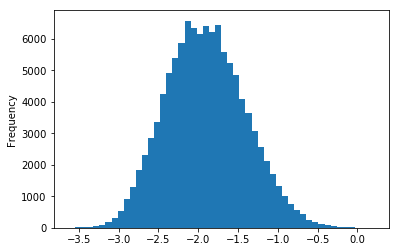

In [25]:
df.loc[train_index].Score_bki.plot.hist(bins=50);

Зависимость WoE от признака

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app


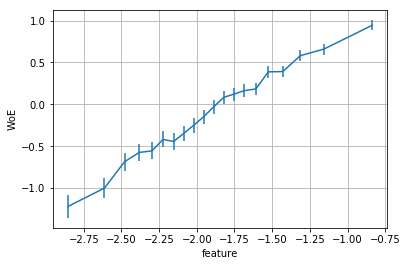

In [35]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].Score_bki, nbuck=20)

Считаем IV

In [27]:
IV(y.loc[train_index].default_flg, df.loc[train_index].Score_bki, nbuck=20)

0.283108532383257

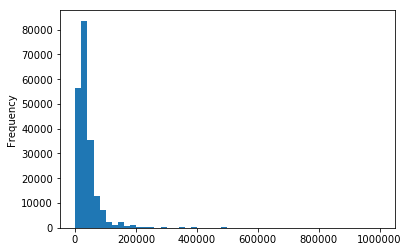

In [28]:
df.income.plot.hist(bins=50);

У признака доход зависимость WoE не такая линейная, как у Score_bki.

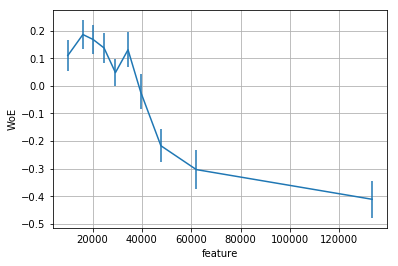

In [29]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].income, nbuck=10)

WoE от преобразованного признака

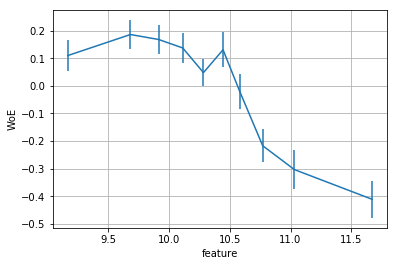

In [30]:
WoE(y.loc[train_index].default_flg, df.loc[train_index].income.apply(lambda x: np.log(x)), nbuck=10)

Посчитаем IV от различных преобразований поля income

In [31]:
print (IV(y.loc[train_index].default_flg, df.loc[train_index].income, nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].income.apply(lambda x: np.log(x)), nbuck=10))
print (IV(y.loc[train_index].default_flg, df.loc[train_index].income.apply(lambda x: int(x > 40000)), nbuck=10))

0.03837794897479724
0.03837794897479724
0.03354139550049351


Видно, что iv у флага "доход > 40000" не сильно меньше, поэтому вводим флаг в замен старого признака.

In [31]:
df['income_40k_flg'] = df.income.apply(lambda x: int(x > 40000))
df.drop('income', axis=1, inplace=True)

#### Логистическая регрессия

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

Выбираем параметр регуляризации на валидационной выборке

In [32]:
print ('%8s %8s %4s' % ('Train','Validate','C'))
for C in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    LR = LogisticRegression(C=C, penalty='l2')
    LR.fit(df.loc[train_index], y.loc[train_index].default_flg)
    AUC_train = roc_auc_score(y.loc[train_index].default_flg, LR.predict_proba(df.loc[train_index])[:,1])
    AUC_validate = roc_auc_score(y.loc[validate_index].default_flg, LR.predict_proba(df.loc[validate_index])[:,1])
    print('%.6f %.6f %f' %  (AUC_train, AUC_validate, C))

   Train Validate    C
0.631389 0.623292 0.000010
0.698338 0.681162 0.000100
0.727944 0.711949 0.001000
0.729356 0.715301 0.010000
0.729289 0.715619 0.100000
0.729276 0.715654 1.000000
0.729275 0.715657 10.000000
0.729275 0.715658 100.000000


Запускаем лучшее решение и сохраняем результат

In [35]:
LR_best = LogisticRegression(C=100, penalty='l2') # <- на самом деле ругуляризация 1/C
LR.fit(df.loc[train_index], y.loc[train_index].default_flg)
test_pd = LR.predict_proba(df.loc[test_index])[:,1]

Выводим коэффициенты

In [36]:
pd.DataFrame(LR.coef_.T, index=df.columns, columns=['coef'])

,coef
age,-0.005598
appl_rej_cnt,0.132157
good_work_flg,-0.253478
Score_bki,0.981245
out_request_cnt,0.067619
region_rating,-0.024926
home_address_cd,0.281607
work_address_cd,0.284008
SNA,0.143680
first_time_cd,-0.092833


Сохраняем результат в csv

In [37]:
test_pd = pd.DataFrame(test_pd, columns=['score'], index=test_index)
test_pd.to_csv('my_submission.csv')
print(test_pd.shape)
test_pd.head(2)

(24480, 1)


,score
id,
180817,0.075688
180818,0.120584
